# Sentiment Analysis on Movie Reviews - Baseline Model

## Introduction
This notebook serves as a baseline model for the **Sentiment Analysis on Movie Reviews** competition. The goal is to classify movie reviews as different sentiment classes.

In this notebook, we will:
1. **Load and explore the dataset**
2. **Preprocess the text (cleaning, tokenization, TF-IDF)**
3. **Train a baseline model (Linear Regression, Logistic Regression, and NN)**
4. **Evaluate its performance**


### Import Libraries

In [18]:
from collections import Counter
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report, 
    confusion_matrix
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import string
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


### Step 1: Data Ingestion

In this step, we load the `train.tsv` file into a Pandas DataFrame and perform basic checks. This includes verifying the overall structure of the dataset (rows and columns) and previewing a few entries with `df.head()`. These actions ensure the data is properly loaded before we proceed with further exploration and analysis.

In [2]:
df = pd.read_csv("train.tsv", sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


---
### Step 2: Data Cleaning

In this step, we ensure the dataset is properly prepared before moving on to deeper analysis and modeling. We also wrap the cleaning steps in a function to be used for later loading test data and do the same cleaning.
1. **Checking for missing values** and removing or correcting any invalid rows (for example, those with empty `Phrase` fields).
2. **Remove the `SentenceId` column**, because it functions purely as an identifier for grouping phrases by sentence and does not provide direct value for our initial baseline model.
3. **Remove rows** where phrase is empty.
4. **Check for duplicates** and address any outliers, ensuring our data is clean and consistent for the subsequent steps.
5. **Lower Case** to standardizes the text, so that words like "Movie" and "movie" are treated as the same token.
6. **Remove Punctuation**: Punctuation is typically not useful for sentiment classification and can add noise, so removing it simplifies the text.
7. **Lemmatization**: Normalize different variations of the same word (e.g., “running” → “run”).

In [3]:
def clean_data(df):
    # 1. Check for missing values
    print("Missing values in each column:")
    print(df.isnull().sum())

    # 2. Remove the SentenceId column
    #    This column is not needed for our baseline model.
    df = df[['PhraseId', 'Phrase','Sentiment']]
    df.shape

    # 3. Reemove rows where phrase is empty.
    initial_count = df.shape[0]
    df = df[df['Phrase'].str.strip() != '']
    removed_empty_count = initial_count - df.shape[0]
    print(f"\nRemoved {removed_empty_count} rows where Phrase was empty.")

    # 4. Check for duplicates
    duplicates_count = df.duplicated().sum()
    df.drop_duplicates(inplace=True)
    print(f"\nNumber of duplicate rows: {duplicates_count}")

    # 5. Lowercasing
    df["Phrase"] = df["Phrase"].str.lower()

    # 6. Remove Punctuation
    df["Phrase"] = df["Phrase"].str.translate(str.maketrans("", "", string.punctuation))

    # 7. Lemmatization
    nltk.download('wordnet', quiet=True)
    lemmatizer = WordNetLemmatizer()
    df["Phrase"] = df["Phrase"].apply(lambda text: " ".join([lemmatizer.lemmatize(word, pos="v") for word in text.split()]))

clean_data(df=df)

Missing values in each column:
PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

Removed 1 rows where Phrase was empty.

Number of duplicate rows: 0


---
### Step 3: Exploratory data analysis

#### Sentiment Distribution

**Purpose**  
Understanding sentiment distribution is important because it reveals class imbalances that could bias the model's learning process. A heavily skewed distribution might mean the model will have difficulty learning the minority classes. By examining the count and percentage of reviews in each sentiment category, we can determine if the dataset is balanced or if we need to apply techniques to address any imbalance.

**Conclusion**  
From the chart, it appears that **neutral (sentiment 2)** dominates the dataset, while **extremely positive (4)** and **extremely negative (0)** are less frequent. Because of this imbalance, we may need to take extra steps to prevent the model from focusing too heavily on the most common sentiment.



Sentiment Distribution (% of total reviews):
 Sentiment  count proportion
         0   7072      4.53%
         1  27273     17.48%
         2  79582     50.99%
         3  32927     21.10%
         4   9206      5.90%


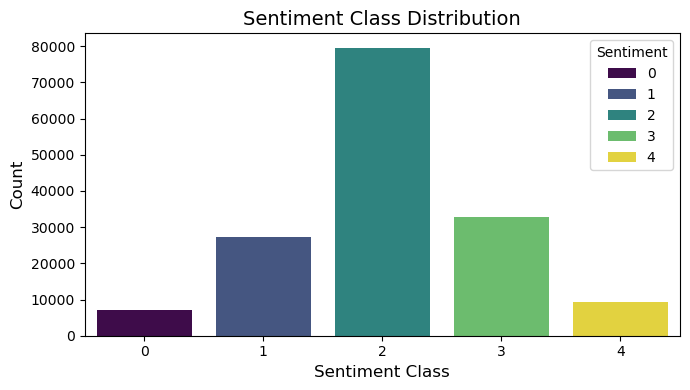

In [4]:
# Calculate the count and percentage of each sentiment class
sentiment_percent = df["Sentiment"].value_counts().reset_index().sort_values(by='Sentiment')
sentiment_percent.columns = ['Sentiment', 'count']
sentiment_percent['proportion'] = sentiment_percent['count'] / df.shape[0] * 100
sentiment_percent['proportion'] = sentiment_percent['proportion'].apply(lambda x: f"{x:.2f}%")

print("Sentiment Distribution (% of total reviews):")
print(sentiment_percent.to_string(index=False))

# Visualize the sentiment distribution
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="Sentiment", hue="Sentiment", palette="viridis")
plt.title('Sentiment Class Distribution', fontsize=14)
plt.xlabel('Sentiment Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

---
### Step 3: Exploratory Data Analysis - cont'd

#### Phrase Length Analysis

**Purpose**  
Examining the length of each phrase (in words) helps us determine whether certain sentiments are associated with shorter or longer text. It also reveals potential outliers (very short or very long phrases) that may skew the model’s performance.

**Conclusion**  
From the boxplot, we see that **neutral** (sentiment 2) phrases tend to be shorter, while other sentiments have higher median lengths and more outliers. This pattern suggests that expressing a stronger sentiment—whether positive or negative—often involves using more words.


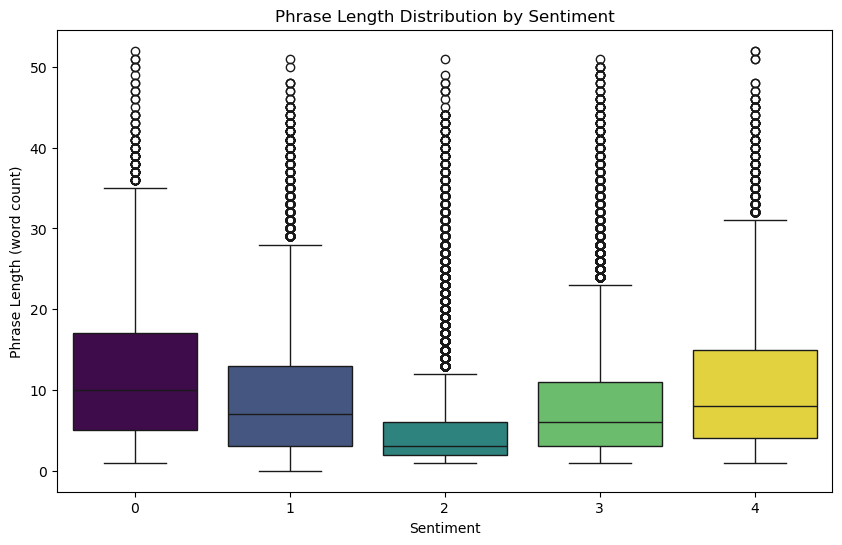

In [5]:
df["Phrase_length"] = df["Phrase"].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.boxplot(x='Sentiment', y='Phrase_length', data=df, hue='Sentiment', palette="viridis")
plt.title("Phrase Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Phrase Length (word count)")
plt.legend('', frameon=False)
plt.show()

---
### Step 3: Exploratory Data Analysis - cont'd

#### Most Common Words by Sentiment

**Purpose**  
By identifying the top words for each sentiment category, we can see how language differs across very negative (0), negative (1), neutral (2), positive (3), and very positive (4) phrases. This insight helps us understand which words are common filler terms versus which words might be truly indicative of a certain sentiment.

**Conclusion**  
We observe that some words (e.g., "the", "and") appear frequently in all sentiments, suggesting they are general filler words. Meanwhile, other words—though not immediately obvious from this particular top-10 list—may be more sentiment-specific and could help differentiate negative from positive phrases. These findings can guide us in refining our stopwords list or engineering sentiment-focused features for more accurate classification.


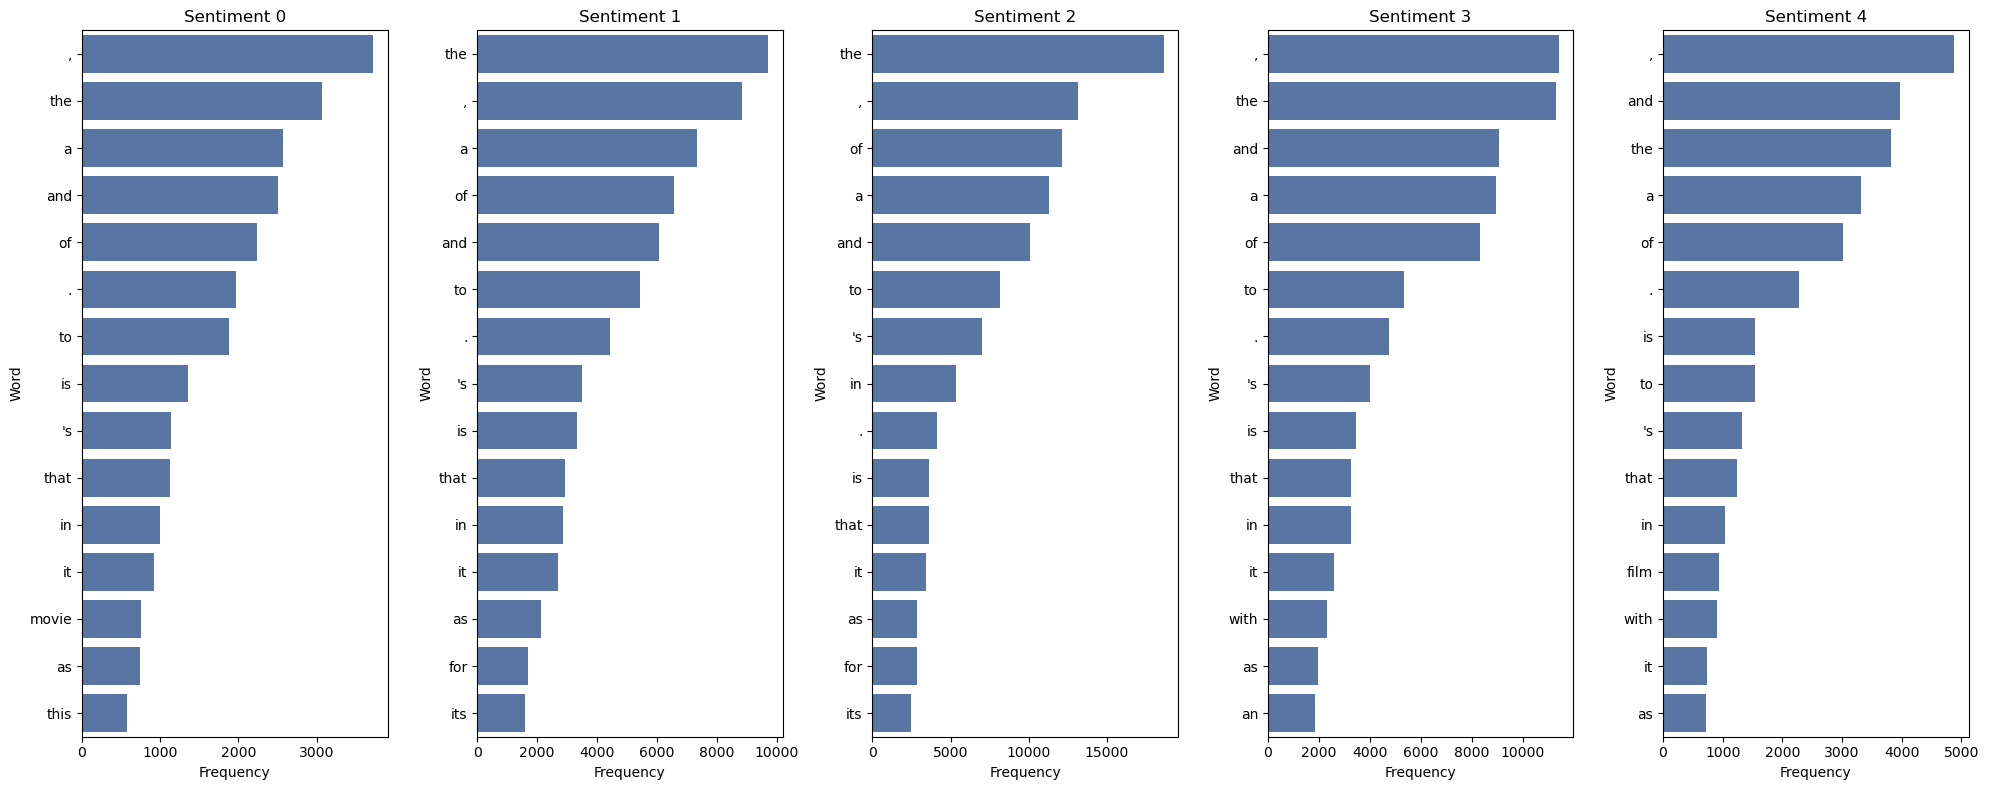

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
sentiments = sorted(df['Sentiment'].unique())
for i, sentiment in enumerate(sentiments):
    subset = df[df['Sentiment'] == sentiment]
    word_counts = Counter(" ".join(subset["Phrase"]).split())
    common_words = word_counts.most_common(15)
    sns.barplot(ax=axes[i],
                x=[count for _, count in common_words],
                y=[word for word, _ in common_words],
                orient='h', color='#4c72b0')
    axes[i].set_title(f"Sentiment {sentiment}")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("Word")

plt.tight_layout()
plt.show()


---
### Step 4: Data Preprocessing

In this step, we standardize and transform the text data to prepare it for modeling.
   
1. **Stopword Removal:**  
   We define a set of English stopwords (using NLTK) to filter out common words (like "the", "and", etc.) that generally don't contribute to sentiment detection.  
   *Note:* We allow update to this stopwords set.

2. **TF-IDF Vectorization:**  
   We convert the cleaned text into numerical features using TF-IDF, which captures both the term frequency and the relative importance of words across all documents.  
   The TF-IDF vectorizer is fitted on the training set and then used to transform the test set, ensuring that the feature representation is consistent and avoids data leakage.


In [33]:

# Download NLTK stopwords
nltk.download('stopwords')

# Load default stopwords
stop_words = set(stopwords.words("english"))

# Add custom stopwords
additional_stopwords = {"example", "anotherword"}
stop_words.update(additional_stopwords)

# Remove important words (negations etc.)
important_words = {
    "not", "no", "never", "none", "nor", "nothing", "nowhere",
    "hardly", "barely", "scarcely", "very", "too", "so", "just",
    "quite", "rather", "almost", "much",
    "aren't", "couldn't", "didn't", "doesn't", "hadn't", "hasn't",
    "haven't", "isn't", "mightn't", "mustn't", "needn't", "shan't",
    "shouldn't", "wasn't", "weren't", "won't", "wouldn't"
}
stop_words = stop_words - important_words

# Convert set to list (IMPORTANT FIX)
stop_words = list(stop_words)

# Initialize the TF-IDF Vectorizer with the **custom stopwords list**
vectorizer = TfidfVectorizer(
    stop_words=stop_words,  # Now it's a list, works correctly
    max_features=5000
)

# Apply TF-IDF
X = vectorizer.fit_transform(df["Phrase"])
y = df["Sentiment"]

# Shape check
print(f"TF-IDF feature matrix shape: {X.shape}")

# Analyze top words for first sample
feature_names = vectorizer.get_feature_names_out()
first_text_vector = X[0].toarray().flatten()

# Top 10 words
top_n = 10
top_indices = np.argsort(first_text_vector)[::-1][:top_n]
top_words = [feature_names[i] for i in top_indices]
top_scores = [first_text_vector[i] for i in top_indices]

print("Top TF-IDF words in first text:")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.4f}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TF-IDF feature matrix shape: (156060, 5000)
Top TF-IDF words in first text:
good: 0.4535
goose: 0.3953
amounts: 0.3812
occasionally: 0.3334
none: 0.3280
series: 0.3044
also: 0.2789
much: 0.2339
story: 0.2209
80: 0.0000


---

### Step 4: Data Preprocessing - cont'd

#### Train, Validation, Test Split
1. **Split into Train and Validation Sets**: Divide the training data (from `train.tsv`) into 60% for training, 20% for validation, 20% for tests.


In [34]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Train set: (93636, 5000), Validation set: (31212, 5000), Test set: (31212, 5000)


---
### Step 5: BaseLine Models

#### 5-1. Logistic Regression Classification model


Logistic Regression - Evaluation Metrics
Accuracy (LR): 0.6230
Precision (Weighted) (LR): 0.6043
Recall (Weighted) (LR): 0.6230
F1 Score (Weighted) (LR): 0.5931

Classification Report (LR):
              precision    recall  f1-score   support

           0       0.58      0.17      0.27      1376
           1       0.51      0.34      0.41      5403
           2       0.67      0.87      0.75     16065
           3       0.54      0.46      0.50      6539
           4       0.58      0.22      0.32      1829

    accuracy                           0.62     31212
   macro avg       0.58      0.41      0.45     31212
weighted avg       0.60      0.62      0.59     31212



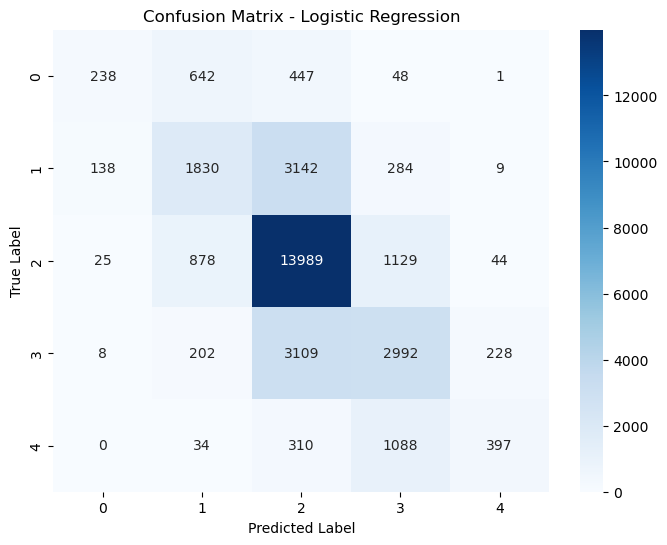

In [38]:
# Train the Logistic Regression classification model

model_logistic = LogisticRegression(max_iter=500)
model_logistic.fit(X_train, y_train)

y_pred_logistic = model_logistic.predict(X_test)
acc_logistic = accuracy_score(y_test, y_pred_logistic)

# Evaluation Metrics
accuracy_LR = accuracy_score(y_test, y_pred_logistic)
precision_LR = precision_score(y_test, y_pred_logistic, average='weighted')
recall_LR = recall_score(y_test, y_pred_logistic, average='weighted')
f1_LR = f1_score(y_test, y_pred_logistic, average='weighted')
report_LR = classification_report(y_test, y_pred_logistic)

# Print Summary
print("Logistic Regression - Evaluation Metrics")
print(f"Accuracy (LR): {accuracy_LR:.4f}")
print(f"Precision (Weighted) (LR): {precision_LR:.4f}")
print(f"Recall (Weighted) (LR): {recall_LR:.4f}")
print(f"F1 Score (Weighted) (LR): {f1_LR:.4f}")
print("\nClassification Report (LR):")
print(report_LR)

# Confusion Matrix
conf_matrix_LR  = confusion_matrix(y_test, y_pred_logistic)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_LR, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0,1,2,3,4], 
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


#### 5-2. XGBoost Classification Model


c:\Users\nicol\.conda\envs\tensorflow-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Evaluation Metrics
Accuracy: 0.6102
Precision (Weighted): 0.5929
Recall (Weighted): 0.6102
F1 Score (Weighted): 0.5648

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.23      0.33      1376
           1       0.55      0.24      0.34      5403
           2       0.63      0.92      0.75     16065
           3       0.56      0.33      0.41      6539
           4       0.58      0.27      0.37      1829

    accuracy                           0.61     31212
   macro avg       0.57      0.40      0.44     31212
weighted avg       0.59      0.61      0.56     31212



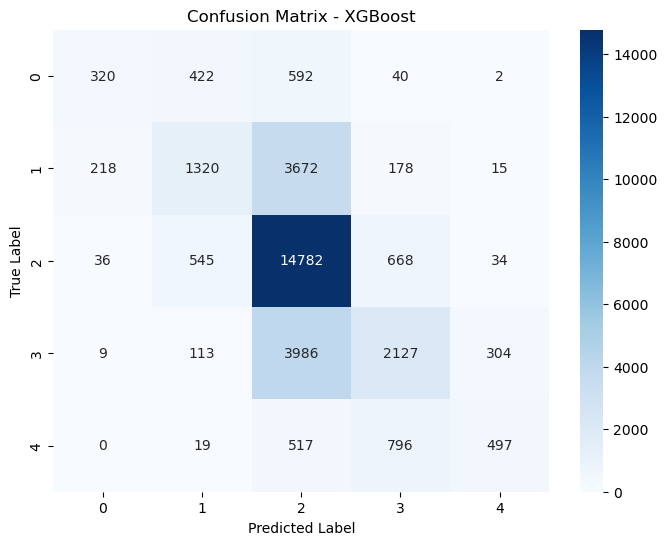

In [37]:
# Train the XGBoost classification model
model_xg = xgb.XGBClassifier(
    objective="multi:softmax",  # Multi-class classification task
    num_class=5,  # 5 sentiment classes (0-4)
    max_depth=10,  # Maximum tree depth
    learning_rate=0.1,  # Learning rate
    n_estimators=500,  # Number of trees
    eval_metric="mlogloss",  # Multi-class loss function
    use_label_encoder=False  # Disable default label encoding
)
model_xg.fit(X_train, y_train)

# Make predictions
y_pred_xg  = model_xg.predict(X_test)

# Evaluate and Calculate accuracy
accuracy_xg = accuracy_score(y_test, y_pred_xg)
precision_xg = precision_score(y_test, y_pred_xg, average='weighted')
recall_xg = recall_score(y_test, y_pred_xg, average='weighted')
f1_xg = f1_score(y_test, y_pred_xg, average='weighted')
report_xg = classification_report(y_test, y_pred_xg)

# Print Summary
print("\nXGBoost - Evaluation Metrics")
print(f"Accuracy: {accuracy_xg:.4f}")
print(f"Precision (Weighted): {precision_xg:.4f}")
print(f"Recall (Weighted): {recall_xg:.4f}")
print(f"F1 Score (Weighted): {f1_xg:.4f}")
print("\nClassification Report:")
print(report_xg)

# Confusion Matrix
conf_matrix_xg = confusion_matrix(y_test, y_pred_xg)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_xg, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4], 
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()

#### 5-3. LightGBM Classification Model

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84774
[LightGBM] [Info] Number of data points in the train set: 93636, number of used features: 3736
[LightGBM] [Info] Start training from score -3.078013
[LightGBM] [Info] Start training from score -1.742866
[LightGBM] [Info] Start training from score -0.678748
[LightGBM] [Info] Start training from score -1.548695
[LightGBM] [Info] Start training from score -2.827601


c:\Users\nicol\.conda\envs\tensorflow-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM - Evaluation Metrics
Accuracy (LGBM): 0.6316
Precision (Weighted) (LGBM): 0.6119
Recall (Weighted) (LGBM): 0.6316
F1 Score (Weighted) (LGBM): 0.6042

Classification Report (LGBM):
              precision    recall  f1-score   support

           0       0.50      0.29      0.36      1376
           1       0.53      0.33      0.41      5403
           2       0.67      0.88      0.76     16065
           3       0.57      0.42      0.49      6539
           4       0.58      0.31      0.41      1829

    accuracy                           0.63     31212
   macro avg       0.57      0.45      0.49     31212
weighted avg       0.61      0.63      0.60     31212



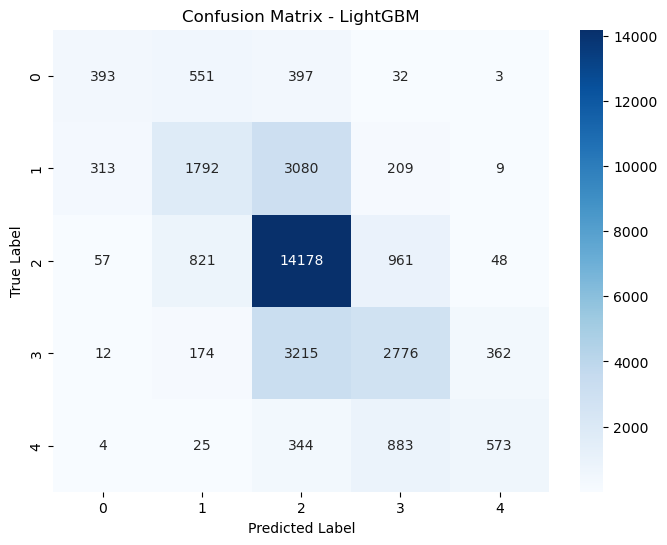

In [39]:
# Initialize LightGBM model

model_gbm = LGBMClassifier(
    n_estimators=200,
    num_leaves=63,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=1234
)
model_gbm.fit(X_train, y_train)

# Predict
y_pred_gbm = model_gbm.predict(X_test)

# Evaluation Metrics
accuracy_LGBM = accuracy_score(y_test, y_pred_gbm)
precision_LGBM = precision_score(y_test, y_pred_gbm, average='weighted')
recall_LGBM = recall_score(y_test, y_pred_gbm, average='weighted')
f1_LGBM = f1_score(y_test, y_pred_gbm, average='weighted')
report_LGBM = classification_report(y_test, y_pred_gbm)

# Print Summary
print("LightGBM - Evaluation Metrics")
print(f"Accuracy (LGBM): {accuracy_LGBM:.4f}")
print(f"Precision (Weighted) (LGBM): {precision_LGBM:.4f}")
print(f"Recall (Weighted) (LGBM): {recall_LGBM:.4f}")
print(f"F1 Score (Weighted) (LGBM): {f1_LGBM:.4f}")
print("\nClassification Report (LGBM):")
print(report_LGBM)

# Confusion Matrix
conf_matrix_LGBM = confusion_matrix(y_test, y_pred_gbm)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_LGBM, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4], 
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()

#### 5-4. Neural Network model

In [42]:

# Train Neural Network model

def build_model(n_classes=5, 
                 input_dim=5000, 
                 hidden_layer_sizes=[],
                 activation='relu',
                 optimizer='adam',
                 learning_rate=0.01,
                 metric='accuracy'):
    """
    Build a neural network model for multi-class sentiment classification.
    Args:
    - n_classes: Number of sentiment classes (5: 0-4).
    - input_dim: Input dimension (number of TF-IDF features).
    - hidden_layer_sizes: List of hidden layer sizes (e.g., [512, 256]).
    - activation: Activation function (e.g., 'relu', 'tanh').
    - optimizer: Optimizer to use (e.g., 'adam', 'sgd').
    - learning_rate: Learning rate for optimizer.
    - metric: Evaluation metric to track.

    Returns:
    - model: Compiled tf.keras model.
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Start building model
    model_nn = keras.Sequential()

    # Input layer (TF-IDF size)
    model_nn.add(keras.layers.Input(shape=(input_dim,)))

    # Hidden layers
    for units in hidden_layer_sizes:
        model_nn.add(keras.layers.Dense(units, activation=activation))
        model_nn.add(keras.layers.Dropout(0.3))  # Optional regularization

    # Output layer (5 sentiment classes)
    model_nn.add(keras.layers.Dense(n_classes, activation='softmax'))

    # Select optimizer
    if optimizer.lower() == 'adam':
        optimizer_instance = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'sgd':
        optimizer_instance = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    # Compile the model
    model_nn.compile(optimizer=optimizer_instance,
                  loss='categorical_crossentropy',  # Because of one-hot encoding
                  metrics=[metric])

    return model_nn



In [46]:
def train_and_evaluate_nn(hidden_layer_sizes=[512, 256],
                          activation='relu',
                          optimizer='adam',
                          learning_rate=0.01,
                          num_epochs=10,
                          batch_size=32):
    """
    Train and evaluate a Neural Network for sentiment analysis.
    All hyperparameters have default values but can be overridden.
    """

    print(f"\nTraining with config - hidden_layer_sizes: {hidden_layer_sizes}, "
          f"activation: {activation}, optimizer: {optimizer}, learning_rate: {learning_rate}")

    # Build model using the passed (or default) hyperparameters
    model = build_model(
        n_classes=5,
        input_dim=X_train.shape[1],
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        optimizer=optimizer,
        learning_rate=learning_rate
    )

    # One-hot encode labels
    y_train_nn = keras.utils.to_categorical(y_train, 5)
    y_test_nn = keras.utils.to_categorical(y_test, 5)

    # Train model
    history = model.fit(
        X_train, y_train_nn,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test_nn),
        verbose=0
    )

    # Evaluate
    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    y_pred_nn = model.predict(X_test)
    y_pred_nn_labels = np.argmax(y_pred_nn, axis=1)
    y_test_labels = np.argmax(y_test_nn, axis=1)

    precision = precision_score(y_test_labels, y_pred_nn_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_nn_labels, average='weighted')
    f1 = f1_score(y_test_labels, y_pred_nn_labels, average='weighted')

    # Summary
    print(f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, F1: {f1:.4f}\n")

    # Return results as dictionary (for tracking in a list if needed)
    return {
        'hidden_layer_sizes': hidden_layer_sizes,
        'activation': activation,
        'optimizer': optimizer,
        'learning_rate': learning_rate,
        'train_accuracy': round(train_accuracy, 2),
        'val_accuracy': round(val_accuracy, 2),
        'precision': round(precision, 2),
        'recall': round(recall, 2),
        'f1': round(f1, 2)
    }


train_and_evaluate_nn()



Training with config - hidden_layer_sizes: [512, 256], activation: relu, optimizer: adam, learning_rate: 0.01
976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Train Accuracy: 0.7112, Val Accuracy: 0.6397, F1: 0.6106



{'hidden_layer_sizes': [512, 256],
 'activation': 'relu',
 'optimizer': 'adam',
 'learning_rate': 0.01,
 'train_accuracy': 0.71,
 'val_accuracy': 0.64,
 'precision': 0.63,
 'recall': 0.64,
 'f1': 0.61}

#### 5-5. Random Forest Model

In [16]:
# # Initialize Random Forest model 

# model_RF = RandomForestClassifier(n_estimators=100, random_state=1234, n_jobs=10)
# model_RF.fit(X_train, y_train)

# # Predict on test data
# y_pred = model_RF.predict(X_test)

# # Fit model on training data
# model_RF.fit(X_train, y_train)

# # Predict on test data
# y_pred = model_RF.predict(X_test)

# # Evaluate
# acc_RF= accuracy_score(y_test, y_pred)
# print(f"Random Forest Accuracy: {acc_RF:.4f}")

# # Print classification report
# print(classification_report(y_test, y_pred))

---
### Step 6: Hyperparameter Tunning

#### Model Selection Summary

After evaluating several models, including **Logistic Regression**, **Random Forest**, **LightGBM**, and **XGBoost**,  
we have selected the **Neural Network** as the best-performing model for the sentiment analysis task.

This decision is based on a comprehensive comparison of evaluation metrics such as accuracy, precision, recall,  
F1-score, and confusion matrices. While some traditional models demonstrated faster training times,  
they consistently struggled to capture the **complex relationships between words and sentiment**,  
especially in handling **subtle contextual patterns and polarity shifts**.

The Neural Network, with a baseline architecture of **[512, 256] hidden layers using ReLU activation and Adam optimizer**,  
achieved the following performance:

- **Train Accuracy:** 0.7112
- **Validation Accuracy:** 0.6397
- **F1 Score:** 0.6106

These results demonstrate that the Neural Network, despite being more complex,  
is better able to generalize to unseen data compared to simpler models.  
Based on this, we have decided to focus the next stage of our work on **hyperparameter tuning for the Neural Network**,  
aiming to further improve its generalization performance.


In [54]:
nn_configurations = [
    {'hidden_layer_sizes': [512, 256], 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01},
    {'hidden_layer_sizes': [256, 128], 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01},
    {'hidden_layer_sizes': [128], 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.01},
    {'hidden_layer_sizes': [512], 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.01},
]

results = []
for config in nn_configurations:
    result = train_and_evaluate_nn(**config, num_epochs=10)
    results.append(result)

df_results = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(df_results)


Training with config - hidden_layer_sizes: [512, 256], activation: relu, optimizer: adam, learning_rate: 0.01
976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Train Accuracy: 0.7048, Val Accuracy: 0.6339, F1: 0.6040


Training with config - hidden_layer_sizes: [256, 128], activation: relu, optimizer: adam, learning_rate: 0.01
976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Train Accuracy: 0.7058, Val Accuracy: 0.6339, F1: 0.6075


Training with config - hidden_layer_sizes: [128], activation: tanh, optimizer: adam, learning_rate: 0.01
976/976 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Train Accuracy: 0.7946, Val Accuracy: 0.5535, F1: 0.5466


Training with config - hidden_layer_sizes: [512], activation: relu, optimizer: sgd, learning_rate: 0.01
976/976 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Train Accuracy: 0.5197, Val Accuracy: 0.5263, F1: 0.3917


Hyperparameter Tuning Results:
  hidden_layer_sizes activation optimizer  learning_rate  train_accuracy  \
0         [512, 256]       relu      adam           0.01       

c:\Users\nicol\.conda\envs\tensorflow-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---
### Step 7: Evaluation

### Hyperparameter Tuning Summary

We performed an initial round of hyperparameter tuning for the Neural Network model, exploring different combinations of:

- Hidden Layer Sizes (depth and width of the network)
- Activation Functions (ReLU vs Tanh)
- Optimizers (Adam vs SGD)
- Learning Rate (fixed at 0.01 for this round)

---

#### Summary of Results

| Configuration | Train Accuracy | Validation Accuracy | F1 Score | Notes |
|---|---|---|---|---|
| [512, 256], relu, adam | 0.71 | 0.64 | 0.61 | Strong balanced performance |
| [256, 128], relu, adam | 0.71 | 0.64 | 0.61 | Smaller network performs just as well |
| [128], tanh, adam | 0.79 | 0.56 | 0.55 | Overfitting (train much higher than val) |
| [512], relu, sgd | 0.52 | 0.53 | 0.39 | Poor training and generalization (SGD struggles) |

---

#### Key Observations

1. Adam significantly outperforms SGD.
2. Smaller networks (e.g., [256, 128]) achieve nearly the same performance as larger networks, suggesting that the task does not require extremely deep models.
3. Tanh tends to overfit, reaching very high training accuracy but much lower validation accuracy.
4. ReLU with Adam emerges as the most consistent and stable choice, with solid performance across different layer sizes.

---

#### Conclusion

Based on these results, the recommended configuration for further refinement is:

- Hidden Layer Sizes: [256, 128]
- Activation: ReLU
- Optimizer: Adam
- Learning Rate: 0.01

This architecture achieves a good balance between performance and simplicity, making it a strong candidate for further tuning (e.g., adjusting learning rate, adding regularization, increasing epoch count, and exploring batch normalization).
